In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix


In [2]:

# Load dataset
data = load_breast_cancer()
X, y = data.data, data.target

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features (important for Logistic Regression)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [3]:

from sklearn.svm import SVC

svc = SVC(max_iter=10000, probability=True)
preds_svc = svc.fit(X_train, y_train).predict(X_test)

probs_svc = svc.decision_function(X_test)
probs_svc = (probs_svc - probs_svc.min()) / (probs_svc.max() - probs_svc.min())

Accuracy (Uncalibrated) = 98.25%
Log Loss (Uncalibrated) = 0.2666


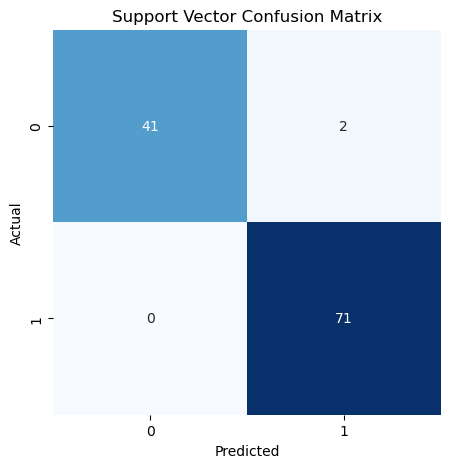

In [7]:
# Compute accuracy
svc_test_acc = round(accuracy_score(y_test, preds_svc) * 100, 2)
print(f'Accuracy (Uncalibrated) = {svc_test_acc}%')

# Compute Log Loss
orig_log_loss = log_loss(y_test, probs_svc)
print(f'Log Loss (Uncalibrated) = {orig_log_loss:.4f}')

# Plot Confusion Matrix
cm = confusion_matrix(y_test, preds_svc)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Support Vector Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [15]:
# Apply Platt Scaling using CalibratedClassifierCV on SVC model
calibrated_svc = CalibratedClassifierCV(svc, cv=2, method='sigmoid')
calibrated_svc.fit(X_train, y_train)

# Get calibrated probability estimates
svc_calibrated_probs = calibrated_svc.predict_proba(X_test)[:, 1]

# Make calibrated predictions
y_pred_svc_calibrated = calibrated_svc.predict(X_test)

# Evaluate performance
calibrated_svc_acc = accuracy_score(y_test, y_pred_svc_calibrated)
calibrated_svc_log_loss = log_loss(y_test, svc_calibrated_probs)

print(f'Accuracy (Calibrated SVC) = {calibrated_svc_acc * 100:.2f}%')
print(f'Log Loss (Calibrated SVC) = {calibrated_svc_log_loss:.4f}')


Accuracy (Calibrated SVC) = 95.61%
Log Loss (Calibrated SVC) = 0.0872


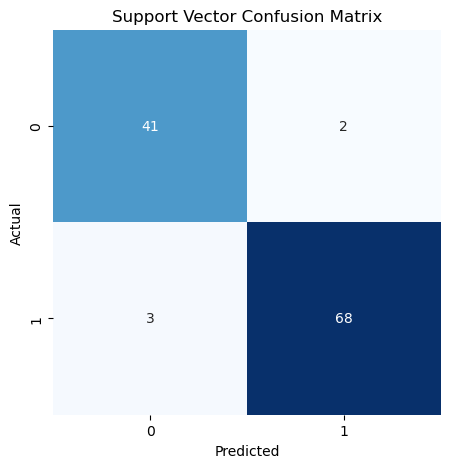

In [35]:
# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred_svc_calibrated)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Support Vector Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [43]:
import numpy as np

def expected_calibration_error_manual(y_true, probs, n_bins=10):
    """
    Compute the Expected Calibration Error (ECE) using manual binning.
    
    Parameters:
        y_true : array-like of shape (n_samples,)
            True binary labels.
        probs : array-like of shape (n_samples,)
            Predicted probabilities for the positive class.
        n_bins : int
            Number of bins to divide the probability interval [0, 1].
            
    Returns:
        ece : float
            Expected Calibration Error.
    """
    # Define bin edges uniformly between 0 and 1
    bin_edges = np.linspace(0, 1, n_bins + 1)
    ece = 0.0
    n = len(probs)
    
    # Loop over each bin
    for i in range(n_bins):
        # For the last bin, include the right edge
        if i == n_bins - 1:
            bin_idx = (probs >= bin_edges[i]) & (probs <= bin_edges[i+1])
        else:
            bin_idx = (probs >= bin_edges[i]) & (probs < bin_edges[i+1])
        
        bin_count = np.sum(bin_idx)
        if bin_count > 0:
            # Mean predicted probability in the bin
            mean_prob = np.mean(probs[bin_idx])
            # Fraction of positives (observed frequency) in the bin
            frac_pos = np.mean(y_true[bin_idx])
            # Weight the absolute difference by the proportion of samples in the bin
            ece += np.abs(frac_pos - mean_prob) * (bin_count / n)
            
    return ece

# Compute ECE for the uncalibrated model using manual binning
ece_svc_uncalibrated = expected_calibration_error_manual(y_test, probs_svc, n_bins=10)
print(f'Expected Calibration Error (Uncalibrated SVC) = {ece_svc_uncalibrated:.4f}')

# Compute ECE for the calibrated model using manual binning
ece_svc_calibrated = expected_calibration_error_manual(y_test, svc_calibrated_probs, n_bins=10)
print(f'Expected Calibration Error (Calibrated SVC) = {ece_svc_calibrated:.4f}')


Expected Calibration Error (Uncalibrated SVC) = 0.1947
Expected Calibration Error (Calibrated SVC) = 0.0353
